# Clothing Classification

Classifying fashion objects into its relevant category using the Fashion MNIST dataset.

In [15]:
import numpy as np
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.layers import Input, Flatten
from keras.layers.core import Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Model
from keras.models import load_model
from keras.optimizers import SGD
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

%matplotlib inline

## 1. Loading the dataset

We can use the built-in helpers in keras to load the fashion mnist dataset below.

It can be seen that it comprises of `60,000` samples in the training dataset, with each sample an image of `28x28`.

There are `10,000` samples in the test set

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
Showing some sample images...



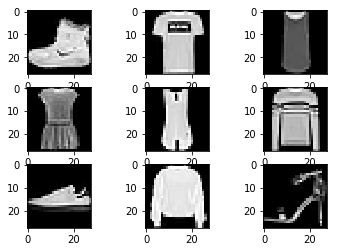

In [49]:
(Xtrain, ytrain), (Xtest, ytest) = fashion_mnist.load_data()
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)


print("Showing some sample images...")
print()
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(Xtrain[i], cmap=plt.get_cmap("gray"))

plt.show()

## 2. Data preparation

The training and test datasets must be reshaped to have a single channel since this is the expected format for passing to a CNN layer. As its a grayscale image, we set the channel value to be `1`.

We also need to one-hot encode the labels. This is done using the `to_categorical` helper from keras. Another option could be to use the `LabelBinarizer` class from scipy.

Both the train and test datasets are also normalized to have pixel values in the range of 0-1

In [16]:
def load_dataset():
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [17]:
def process_data(trainX, testX):
    trainX = trainX.astype("float32")
    testX = testX.astype("float32")
    trainX /= 255.0
    testX /= 255.0
    return trainX, testX

In [4]:
trainX, trainY, testX, testY = load_dataset()
trainX, testX = process_data(trainX, testX)
print("TRAINX MIN: {}, MAX: {}".format(trainX.min(), trainX.max()))
print("TEST MIN: {}, MAX: {}".format(testX.min(), testX.max()))
print(trainY[0])

TRAINX MIN: 0.0, MAX: 1.0
TEST MIN: 0.0, MAX: 1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## 3. Building model

We create an initial baseline model to iterate on.

The model has the following structure:
```
INPUT => CONV => RELU => POOL => FC (100) => FC (10)
```

We use the stochastic gradient descent optimizer to optimize the loss which is set to be multiclass log loss as this is a multi class classification problem i.e. we have 10 categories of fashion items.

In [5]:
def baseline_model():
    inputs = Input(shape=(28, 28, 1))
    X = Conv2D(32, (3,3), kernel_initializer="he_uniform")(inputs)
    X = Activation("relu")(X)
    X = MaxPooling2D((2, 2))(X)
    X = Flatten()(X)
    X = Dense(100, kernel_initializer="he_uniform")(X)
    X = Activation("relu")(X)
    X = Dense(10)(X)
    final_layer = Activation("softmax")(X)
    
    model = Model(inputs=inputs, outputs=final_layer)
    opt = SGD(lr=0.01, momentum=0.9)
    
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = baseline_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               540900    
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
__________

## 4. Model evaluation

We train the model using KFold validation of 5 folds.

We set the batch size to be 32 and train it for 10 epochs.

We store the history and evaluation accuracies in 2 lists to generate evaluation metrics.

In [94]:
def evaluate_model(model, X, y, n_folds=5):
    scores = list()
    histories = list()
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    for trainIdx, testIdx in kfold.split(X):
        trainX, trainY, testX, testY = X[trainIdx], y[trainIdx], X[testIdx], y[testIdx]
        
        history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=10, batch_size=32, verbose=0)
        _, acc = model.evaluate(testX, testY, verbose=0)
        print("Acc> {:.3f}%".format(acc))
        scores.append(acc)
        histories.append(history)
    
    return scores, histories

In [21]:
def summarize_performance(scores):
    print("Accuracy: mean={:.3f} std={:.3f} n={:d}".format(np.mean(scores) * 100, np.std(scores)*100, len(scores)))

    
def plot_graphs(histories):
    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(2, 1, figsize=(13, 13))
    
    for i in range(len(histories)):
        # plot loss
        ax[0].set_title("Categorical Loss")
        ax[0].set_xlabel("Epoch #")
        ax[0].set_ylabel("Loss")
        ax[0].plot(histories[i].history["loss"], label="loss", color="blue")
        ax[0].plot(histories[i].history["val_loss"], label="val_loss", color="red")
        ax[0].legend(["loss", "val_loss"])
        
        # plot accuracy
        ax[1].set_title("Classification Accuracy")
        ax[1].set_xlabel("Epoch #")
        ax[1].set_ylabel("Accuracy")
        ax[1].plot(histories[i].history["acc"], label="acc", color="blue")
        ax[1].plot(histories[i].history["val_acc"], label="val_acc", color="red")
        ax[1].legend(["acc", "val_acc"])

    plt.tight_layout()
    plt.show()

def plot_history(history):
  plt.style.use("ggplot")
  (fig, ax) = plt.subplots(2, 1, figsize=(13, 13))

  # plot loss
  ax[0].set_title("Categorical Loss")
  ax[0].set_xlabel("Epochs #")
  ax[0].set_ylabel("Loss")
  ax[0].plot(history.history["loss"], label="loss", color="blue")
  ax[0].plot(history.history["val_loss"], label="val_loss", color="red")
  ax[0].legend(["loss", "val_loss"])

  # plot accuracy
  ax[1].set_title("Classification Accuracy")
  ax[1].set_xlabel("Epochs #")
  ax[1].set_ylabel("Accuracy")
  ax[1].plot(history.history["acc"], label="acc", color="blue")
  ax[1].plot(history.history["val_acc"], label="val_acc", color="red")
  ax[1].legend(["acc", "val_acc"])
    
  plt.tight_layout()
  plt.show()

In [65]:
trainX, trainY, testX, testY = load_dataset()

trainX, testX = process_data(trainX, testX)

model = baseline_model()

scores, histories = evaluate_model(model, trainX, trainY)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 50s 1ms/step - loss: 0.4239 - acc: 0.8489 - val_loss: 0.3281 - val_acc: 0.8828
Epoch 2/10
48000/48000 [==============================] - 53s 1ms/step - loss: 0.2859 - acc: 0.8970 - val_loss: 0.3047 - val_acc: 0.8886
Epoch 3/10
48000/48000 [==============================] - 74s 2ms/step - loss: 0.2444 - acc: 0.9107 - val_loss: 0.2597 - val_acc: 0.9057
Epoch 4/10
48000/48000 [==============================] - 77s 2ms/step - loss: 0.2157 - acc: 0.9205 - val_loss: 0.2539 - val_acc: 0.9091
Epoch 5/10
48000/48000 [==============================] - 74s 2ms/step - loss: 0.1918 - acc: 0.9300 - val_loss: 0.2943 - val_acc: 0.8958
Epoch 6/10
48000/48000 [==============================] - 77s 2ms/step - loss: 0.1716 - acc: 0.9357 - val_loss: 0.2836 - val_acc: 0.8970
Epoch 7/10
48000/48000 [==============================] - 69s 1ms/step - loss: 0.1544 - acc: 0.9438 - val_loss: 0.2620 - val_acc

NameError: name 'mean' is not defined

In [68]:
summarize_performance(scores)

Accuracy: mean=96.560 std=3.437 n=5


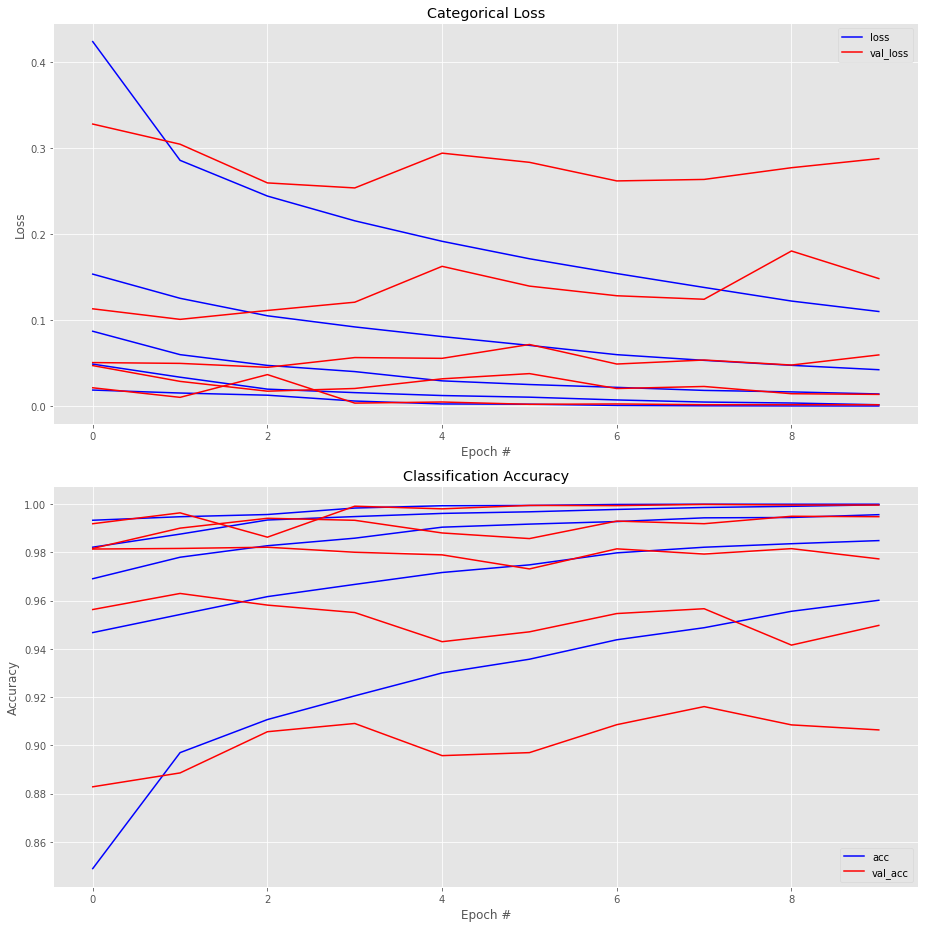

In [90]:
plot_graphs(histories)

From above plots, it can be seen that the training and test curves converge as training progresses, indicating a good fit.

The average accuracy is `96.56%` with a std deviation of `3.43`. We can try to improve on the accuracy rate by making changes to the model structure.

## Extensions

Below are some experiments to try to improve the above model's performance:

* Add padding to the conv layer

* Increasing number of filters

* Add regularization i.e. dropout, weight decay

* Try a range of learning rates 

* Try increasing the model depth by adding more conv layers or FC layers

In [6]:
def model_v2():
    """
    Creates a model with conv and FC layers with padding and higher nos of filters
    
    Structure is: CONV => RELU => POOL => DENSE => RELU => DENSE => SOFTMAX
    """
    inputs = Input(shape=(28, 28, 1))
    X = Conv2D(64, (3,3), padding="same", kernel_initializer="he_uniform")(inputs)
    X = Activation("relu")(X)
    X = MaxPooling2D((2, 2))(X)
    X = Flatten()(X)
    X = Dense(100, kernel_initializer="he_uniform")(X)
    X = Activation("relu")(X)
    X = Dense(10)(X)
    final_layer = Activation("softmax")(X)
    
    model = Model(inputs=inputs, outputs=final_layer)
    opt = SGD(lr=0.01, momentum=0.9)
    
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = model_v2()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1254500   
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0         
__________

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 97s 2ms/step - loss: 0.4360 - acc: 0.8463 - val_loss: 0.3282 - val_acc: 0.8789
Epoch 2/10
48000/48000 [==============================] - 97s 2ms/step - loss: 0.2882 - acc: 0.8964 - val_loss: 0.2855 - val_acc: 0.8941
Epoch 3/10
48000/48000 [==============================] - 98s 2ms/step - loss: 0.2440 - acc: 0.9108 - val_loss: 0.2689 - val_acc: 0.9003
Epoch 4/10
48000/48000 [==============================] - 98s 2ms/step - loss: 0.2127 - acc: 0.9218 - val_loss: 0.2556 - val_acc: 0.9075
Epoch 5/10
48000/48000 [==============================] - 93s 2ms/step - loss: 0.1877 - acc: 0.9310 - val_loss: 0.2715 - val_acc: 0.9048
Epoch 6/10
48000/48000 [==============================] - 94s 2ms/step - loss: 0.1679 - acc: 0.9380 - val_loss: 0.2532 - val_acc: 0.9096
Epoch 7/10
48000/48000 [==============================] - 98s 2ms/step - loss: 0.1483 - acc: 0.9472 - val_loss: 0.2629 - val_acc

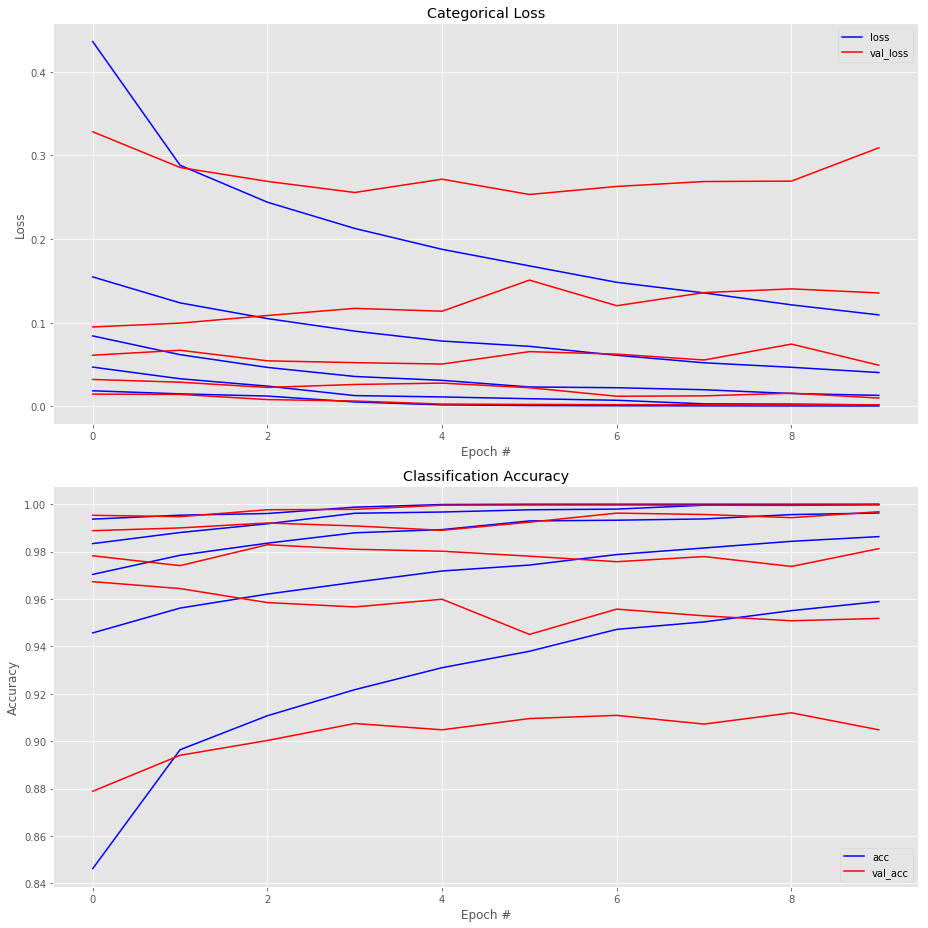

In [93]:
trainX, trainY, testX, testY = load_dataset()

trainX, testX = process_data(trainX, testX)

model = model_v2()
scores, histories = evaluate_model(model, trainX, trainY)

Accuracy: mean=96.690 std=3.538 n=5


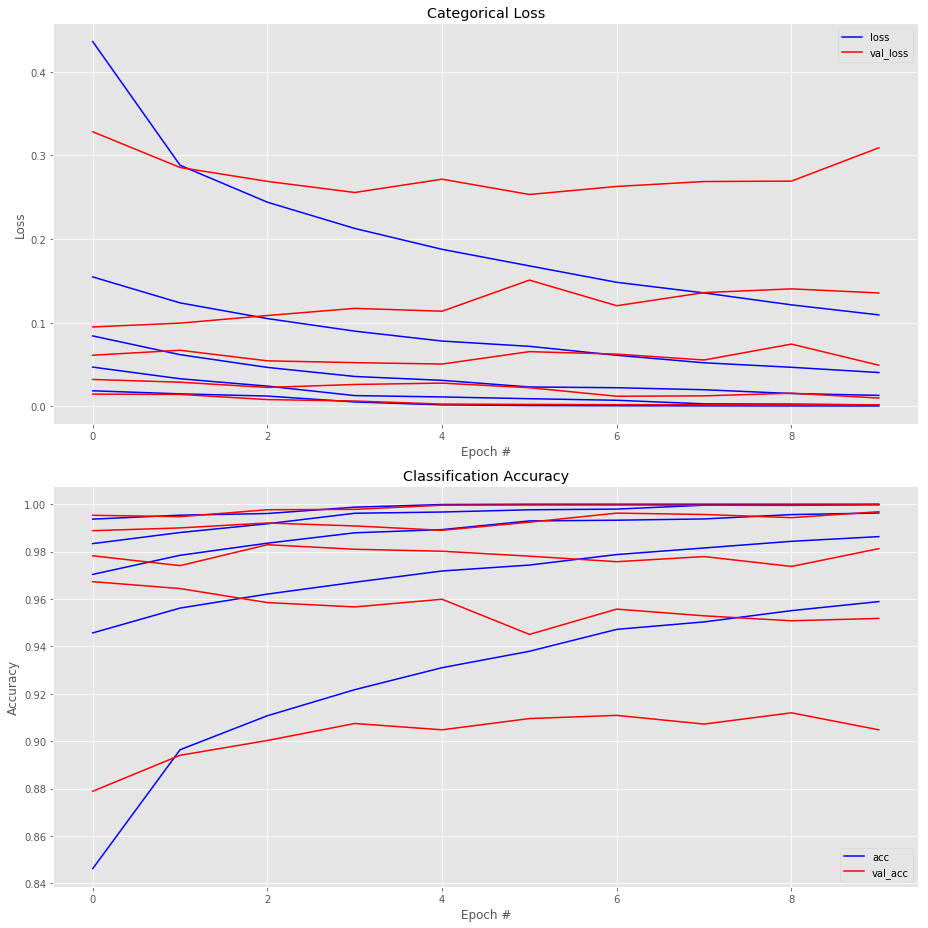

In [98]:
summarize_performance(scores)
plot_graphs(histories)

## Final Model

Saving a final model based on `model_v2` and using it to make predictions.

We load the saved model and evaluate its performance.

Finally, we use the saved model to make a prediction using an unseen sample.

In [7]:
trainX, trainY, testX, testY = load_dataset()

trainX, testX = process_data(trainX, testX)

model = model_v2()

# Create a final model by fitting on training dataset only
# Use the test dataset for evaluation later
model.fit(trainX, trainY, epochs=10, batch_size=32)

model.save("final_mnist_model.model")

Epoch 1/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.4404 - acc: 0.8416
Epoch 2/10
60000/60000 [==============================] - 109s 2ms/step - loss: 0.2845 - acc: 0.8974
Epoch 3/10
60000/60000 [==============================] - 107s 2ms/step - loss: 0.2417 - acc: 0.9120
Epoch 4/10
60000/60000 [==============================] - 106s 2ms/step - loss: 0.2122 - acc: 0.9218
Epoch 5/10
60000/60000 [==============================] - 106s 2ms/step - loss: 0.1886 - acc: 0.9311
Epoch 6/10
60000/60000 [==============================] - 108s 2ms/step - loss: 0.1694 - acc: 0.9371
Epoch 7/10
60000/60000 [==============================] - 110s 2ms/step - loss: 0.1541 - acc: 0.9437
Epoch 8/10
60000/60000 [==============================] - 111s 2ms/step - loss: 0.1375 - acc: 0.9502
Epoch 9/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.1251 - acc: 0.9549
Epoch 10/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.1125 - a

In [9]:
# Evaluate final model
model = load_model("final_mnist_model.model")
loss, acc = model.evaluate(testX, testY)
print("Loss: {:.3f}, Acc: {:.3f}".format(loss * 100, acc*100))

10000/10000 [==============================] - 4s 437us/step
Loss: 30.027, Acc: 90.880


In [18]:
def process_image(path):
    img = load_img(path, color_mode="grayscale", target_size=(28, 28))
    img = img_to_array(img)
    img = img.reshape(1, 28, 28, 1)
    img = img.astype("float32")
    img = img / 255.0
    return img

CATEGORIES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

img = process_image("sample_image.png")
model = load_model("final_mnist_model.model")
result = model.predict(img)
category = np.argmax(result)
print("Category Index: {}".format(category))
print("Predicted Category: {}".format(CATEGORIES[category]))

Category Index: 2
Predicted Category: Pullover


## Extension - Building a deeper model

We will attempt to build a deeper model with more CONV layers with regularization i.e. Dropout and learning rate decay

In [19]:
def model_v3():
    """
    Deeper model similar to VGG net
    """
    
    inputs = Input(shape=(28, 28, 1))
    
    # CONV => RELU => POOL
    X = Conv2D(32, (3, 3), padding="same", kernel_initializer="he_uniform")(inputs)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)
    
    # (CONV => RELU) * 2 => POOL
    X = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_uniform")(X)
    X = Activation("relu")(X)
    X = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_uniform")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)
    
    # (CONV => RELU) * 2 => POOL
    X = Conv2D(128, (3, 3), padding="same", kernel_initializer="he_uniform")(X)
    X = Activation("relu")(X)
    X = Conv2D(128, (3, 3), padding="same", kernel_initializer="he_uniform")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)
    
    # FC layer
    X = Flatten()(X)
    X = Dense(256)(X)
    X = Activation("relu")(X)
    X = Dropout(0.5)(X)
    X = Dense(10)(X)
    X = Activation("softmax")(X)
    
    model = Model(inputs=inputs, outputs=X)
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [13]:
model = model_v3()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 14, 14, 64)        0         
__________

In [24]:
Xtrain, ytrain, Xtest, ytest = load_dataset()
Xtrain, Xtest = process_data(Xtrain, Xtest)

H = model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=10, batch_size=32)
model.save("final_model_v3.model")

loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print("Loss: {:.3f}, Acc: {:.3f}".format(loss, acc))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0314 - acc: 0.9899 - val_loss: 0.4040 - val_acc: 0.9125
Epoch 2/10
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0291 - acc: 0.9902 - val_loss: 0.4263 - val_acc: 0.9120
Epoch 3/10
60000/60000 [==============================] - 108s 2ms/step - loss: 0.0281 - acc: 0.9902 - val_loss: 0.4259 - val_acc: 0.9125
Epoch 4/10
60000/60000 [==============================] - 108s 2ms/step - loss: 0.0240 - acc: 0.9917 - val_loss: 0.4409 - val_acc: 0.9056
Epoch 5/10
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0173 - acc: 0.9947 - val_loss: 0.4381 - val_acc: 0.9148
Epoch 6/10
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0139 - acc: 0.9958 - val_loss: 0.5424 - val_acc: 0.8993
Epoch 7/10
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0177 - acc: 0.9940 - val_loss: 0.4472 - 

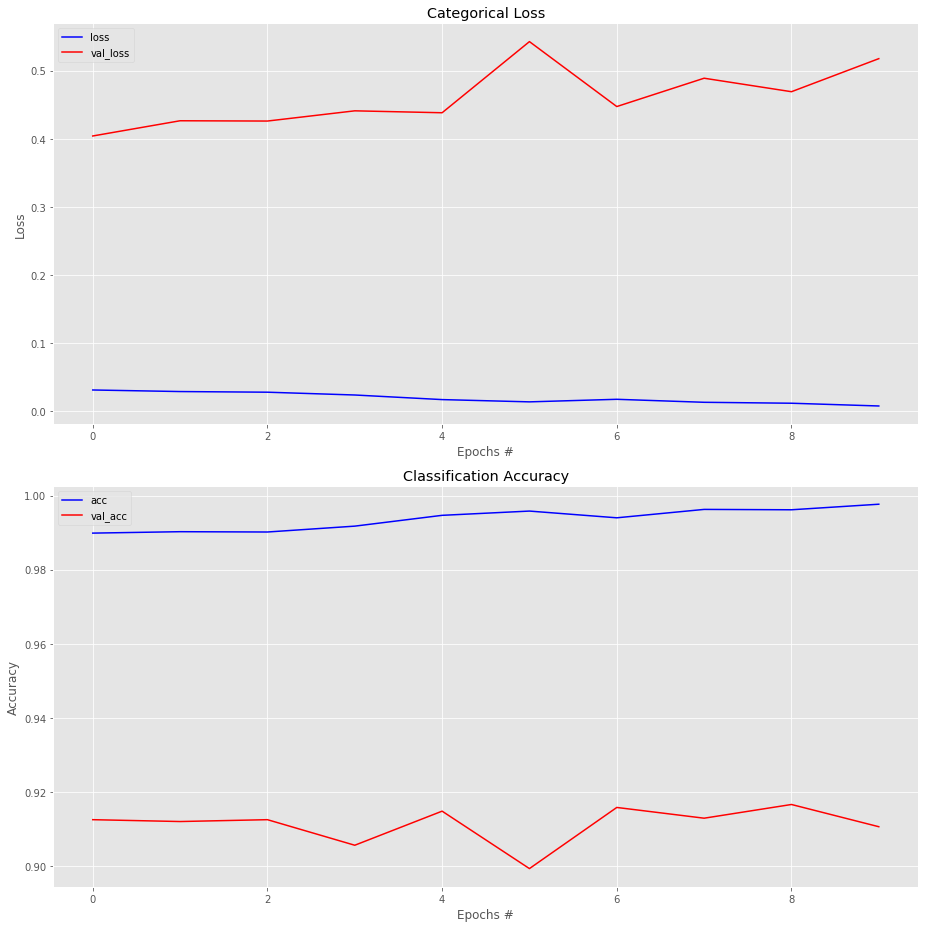

In [25]:
plot_history(H)

In [23]:
img = process_image("sample_image.png")
model = load_model("final_model_v3.model")
result = model.predict(img)
category = np.argmax(result)
print("Category Index: {}".format(category))
print("Predicted Category: {}".format(CATEGORIES[category]))

Category Index: 2
Predicted Category: Pullover


From above, we can see that the accuracy has increased to `91.1%` but the plots still indicate strong overfitting with the validation loss being higher than the training loss.

Perhaps using learning rate decay and training for more epochs might help with the overfitting.